# <span style='font-family:Georgia'> Topic: Image generation with generative adversarial networks  

**Dataset**: sample of the [LSUN Bedrooms Dataset](https://www.kaggle.com/jhoward/lsun_bedroom)

**Requirements**:
- test and compare different network architectures (at least one of them should converge to generate satisfactory images)
- potential architectures (can use different ones): vanilla GAN with CNNs, DC-GAN, Wasserstein GAN, WGAN-GP, SN-GAN, StyleGAN1, StyleGAN2 (with or without data augmentations), StyleGAN3
- calculate the Frechet Inception Distance (FID) for your generated images and compare it to results from literature
- assess your results qualitatively
- investigate the influence of hyperparameters on obtained results
- discuss sets of hyperparameters which help in overcoming training collapse and mode collapse
- select two of your generated images together with their latent vectors; interpolate linearly between the two latent vectors to generate 8 additional latent vectors; use these 8 vectors to generate images from your model; present the 10 generated images (8 newly generated and 2 generated previously) and discuss the importance of the results
    

**Resources**:
- https://walkwithfastai.com/Super_Resolution
- https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-wgan.ipynb
- https://github.com/aarcosg/fastai-course-v3-notes/blob/master/refactored_by_topics/CNN_L7_gan_feature-loss.md
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

- https://github.com/wiseodd/generative-models

In [1]:
# conda create -n fastai python=3.7
# conda activate fastai
# conda install -c conda-forge jupyterlab
# conda install pytorch torchvision torchaudio -c pytorch
# pip install fastai
# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=fastai

In [2]:
import fastai
print(fastai.__version__)
from fastai.vision.gan import *
from fastai.vision.all import *
from fastai.vision.data import *
from tqdm.notebook import tqdm

2.6.3


## <span style='font-family:Georgia'> Approach 1. - WGAN

In [3]:
path = "../../data/sample/data0/lsun/bedroom"

In [4]:
bs = 128
size = 64

In [5]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)],
                  n_inp=1)

In [6]:
dls = dblock.dataloaders(path, path=path, bs=bs)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


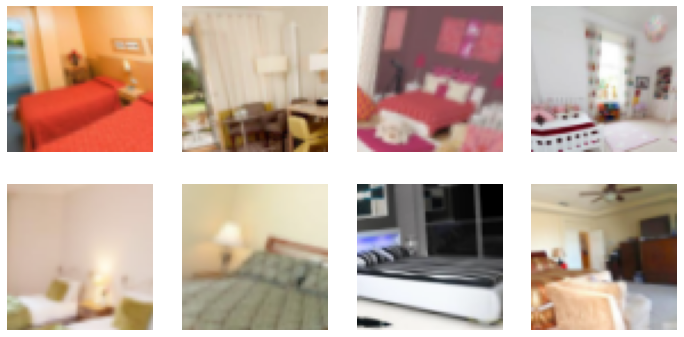

In [7]:
dls.c = 3
dls.show_batch(max_n=8)

In [8]:
generator = basic_generator(out_size=64, n_channels=3, n_extra_layers=1)
critic = gan_critic(n_channels=3)

In [9]:
learn = GANLearner.wgan(dls, generator, critic, switch_eval=False,
                        opt_func = partial(fastai.optimizer.Adam))

In [10]:
# learn.fit_one_cycle(1, 1e-3)

## <span style='font-family:Georgia'> Approach 2. - GAN

In [11]:
path_lr = '../../data/sample/data0/lsun/small-96'
path_hr = '../../data/sample/data0/lsun/bedroom'

In [12]:
from PIL import Image, ImageDraw, ImageFont

In [13]:
# def crappify(fn):
#     dest = path_lr/fn.relative_to(path_hr)
#     dest.parent.mkdir(parents=True, exist_ok=True)
#     img = PIL.Image.open(fn)
#     targ_sz = resize_to(img, 96, use_min=True)
#     img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
#     w,h = img.size
#     q = random.randint(10,70)
#     ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
#     img.save(dest, quality=q)

# for item in tqdm(dls.items):
#     crappify(item)

In [14]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [15]:
class Crappifier():
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
    def __call__(self, fn):       
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [16]:
def get_dls(bs:int, size:int):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [17]:
items = get_image_files(path_hr)

In [ ]:
for item in tqdm(items):
    Crappifier(path_lr, path_hr).__call__(item)

  0%|          | 0/303125 [00:00<?, ?it/s]

In [ ]:
bad_im = get_image_files(path_lr)

In [ ]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

In [ ]:
im1.show(); im2.show(figsize=(5,5))

In [ ]:
dls_gen = get_dls(32, 128)

In [ ]:
dls_gen.show_batch(max_n=8)

In [ ]:
x,y = dls_gen.one_batch()

In [ ]:
x.size()

In [ ]:
y.size()

In [ ]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [ ]:
bbone = resnet34

In [ ]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [ ]:
learn_gen = create_gen_learner()

In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

In [ ]:
learn_gen.unfreeze()

In [ ]:
# learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

In [ ]:
learn_gen.show_results(max_n=8)